Download the support file for IS computation.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/CIS680-VAE-GANs

/content/drive/.shortcut-targets-by-id/1NnmCrND5qB8rccGbJVC7fBwkAGmXwXnk/CIS680-VAE-GANs


# VAE
### Load data for part 1.1 VAE


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2

# FashionMNIST Dataset
train_dataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_batch_size = 100
test_batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Model Definition (TODO)

In [5]:
from scipy.stats.morestats import Mean
class VAE(torch.nn.Module):
  def __init__(self, zdim=5):
    super(VAE,self).__init__()
    ################################
    # Please fill in your code here:
    self.zdim = zdim

    # encoder 
    self.fc1 = nn.Sequential(nn.Linear(784,400),nn.ReLU())
    self.mean_layer = nn.Linear(400,self.zdim,nn.ReLU())
    self.log_var_layer = nn.Linear(400,self.zdim,nn.ReLU())

    # decoder 
    self.fc3 = nn.Sequential(nn.Linear(self.zdim,400),nn.ReLU())
    self.fc4 = nn.Sequential(nn.Linear(400,784),nn.Sigmoid())

    ################################
    
    
  def encode(self, X):
    ################################
    # Please fill in your code here:
    X = self.fc1(X)
    mean = self.mean_layer(X)
    log_var = self.log_var_layer(X)
    ################################
    return mean, log_var

  def decode(self, X):
    ################################
    # Please fill in your code here:
    X = self.fc3(X)
    X = self.fc4(X)
    ################################
    return X

  def reparameterization(self, mean, log_var):
    ################################
    # Please fill in std, eps and z:
    std = torch.exp(0.5*log_var)
    eps = torch.rand_like(std)
    z = mean + (std*eps)
    # z = torch.add(mean, torch.multiply(std,eps))
    ################################
    return z

  def forward(self, X):
    X = X.view(-1,784)
    mean, log_var = self.encode(X)
    z = self.reparameterization(mean, log_var)
    return self.decode(z), mean, log_var


# reparameterization's output is dynamic, for the test case, we use a fixed eps 
# and all the intermediate result is provided. 
# You could use these values to check if you get the final output z correct.
# Or you could add eps to the input when testing the reparameterization module. 
# (warm reminder: don't forget to change back, cause the dynamic reparameterization is the key to VAE) 

# TEST YOUR REPARAMETRIZATION FUNCTION with the values below
testcase_mean = torch.load('test_case_VAE/mean.pt')
testcase_log_var = torch.load('test_case_VAE/log_var.pt')
# check std
testcase_std = torch.load('test_case_VAE/std.pt')
# Since epsilon is random, use the deterministic value of epsilon provided below
testcase_eps = torch.load('test_case_VAE/eps.pt')
testcase_z = torch.load('test_case_VAE/z.pt' )


In [6]:
model = VAE(zdim=5)
model.to(device)

VAE(
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
  (mean_layer): Linear(in_features=400, out_features=5, bias=True)
  (log_var_layer): Linear(in_features=400, out_features=5, bias=True)
  (fc3): Sequential(
    (0): Linear(in_features=5, out_features=400, bias=True)
    (1): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

## VAE Train

### VAE Reconstruction Evaluation (TODO)
For this reconstruction evaluation module, you need to integrate into training procesure.

In [ ]:
# Reconstruction error module
def reconstruction_error(model, test_loader):
    '''
    Argms: 
    Input:
        model: VAE model
        test_loader: Fashion-MNIST test_loader
    Output:
        avg_err: MSE 
    '''
    # set model to eval
    ##################
    model.eval()
    ##################
    # Initialize MSE Loss(use reduction='sum')
    ##################
    criterion = nn.MSELoss(reduction='sum')
    ##################
    recon_err = 0
    idx_counter = 0
    for i, (data,_) in enumerate(test_loader):
        data = data.to(device)
        # feed forward data to VAE
        ##################
        output, _, _ = model.forward(data)
        ##################
        
        idx_counter+=data.shape[0] # sum up the number of images in test_loader

        # flatten the reconstruction output
        ##################
        output = output.view(-1,784)
        data = data.view(-1,784)
        ##################
        # accumulate the MSELoss acrossing the whole test set
        ##################
        recon_err += criterion(output,data)
        ##################
        
    avg_err = recon_err/idx_counter
    return avg_err




In [ ]:
# reconstruction_error(model, test_loader)

### Reconstruction error + KL divergence losses in VAE (TODO)

In [ ]:
# Return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    '''
    Compute reconstruction loss and KL divergence loss mentioned in pdf handout
    '''
    ################################
    # Please compute BCE and KLD:
    bceloss = nn.BCELoss(reduction='sum')
    BCE = bceloss(recon_x.view(-1),x.view(-1))
    KLD = torch.sum(torch.exp(log_var) + torch.pow(mu,2) - 1 - log_var)*0.5
    ################################
    totalloss = BCE + KLD

    return totalloss, BCE, KLD

# def loss_function(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
#     KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)
#     return BCE + KLD, BCE, KLD


#####################################################
# TEST CASE FOR VAE LOSS
#####################################################
testcase_loss_recon_x = torch.load('test_case_VAE/loss_recon_x.pt')
testcase_loss_x = torch.load('test_case_VAE/loss_x.pt')
testcase_loss_mu = torch.load('test_case_VAE/loss_mu.pt')
testcase_loss_log_var = torch.load('test_case_VAE/loss_log_var.pt')
testcase_loss_totalloss = torch.load('test_case_VAE/loss_totalloss.pt')

loss, BCE, KLD = loss_function(testcase_loss_recon_x, testcase_loss_x, testcase_loss_mu, testcase_loss_log_var)
print("test case loss value:", testcase_loss_totalloss.item())
print("computed loss value:", loss.item())


test case loss value: 1426.35888671875
computed loss value: 1426.35888671875


### VAE Training

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 LR: [0.001]
Train Epoch: 1 0% 	Loss: 547.632930 	Recon_err: 129.34788513183594
Train Epoch: 1 17% 	Loss: 282.420156 	Recon_err: 26.044679641723633
Train Epoch: 1 33% 	Loss: 256.761719 	Recon_err: 20.392486572265625
Train Epoch: 1 50% 	Loss: 253.869687 	Recon_err: 19.47991180419922
Train Epoch: 1 67% 	Loss: 247.309395 	Recon_err: 18.838680267333984
Train Epoch: 1 83% 	Loss: 245.038574 	Recon_err: 18.42582130432129
Epoch: 1 Train loss: 265.3162
Epoch: 1 LR: [0.001]
Train Epoch: 2 0% 	Loss: 252.305742 	Recon_err: 17.934438705444336
Train Epoch: 2 17% 	Loss: 252.001719 	Recon_err: 17.762134552001953
Train Epoch: 2 33% 	Loss: 245.051758 	Recon_err: 17.55406951904297
Train Epoch: 2 50% 	Loss: 242.801719 	Recon_err: 17.38154411315918
Train Epoch: 2 67% 	Loss: 252.054355 	Recon_err: 17.22516632080078
Train Epoch: 2 83% 	Loss: 251.830391 	Recon_err: 16.95792579650879
Epoch: 2 Train loss: 246.4158
Epoch: 2 LR: [0.001]
Train Epoch: 3 0% 	Loss: 250.586621 	Recon_err: 16.946779251098633
Tr

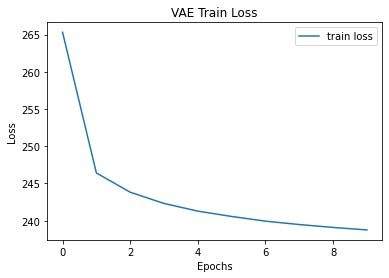

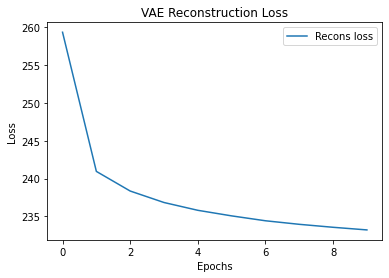

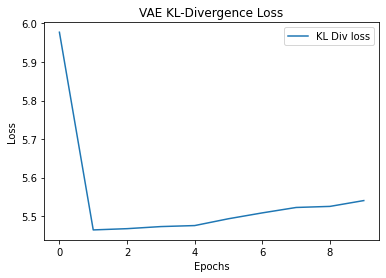

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Z dimension
ZDIM = 5

#Initialize VAE
vae = VAE(ZDIM).to(device)
#Initialize optimizer
optimizer = optim.Adam(vae.parameters(), lr = 1e-3)
#Initialize scheduler(optional)
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)
#num of epochs 
num_epochs = 10
import pdb
train_loss_list = []
recons_loss_list = []
kl_loss_list = []

orig_image_list = []
recon_image_list = []
reconst_error = []

# Define Train loop 
def train(epochs, train_loader, test_loader):
  for epoch in range(epochs):
      vae.train()
      train_loss = 0
      recons_loss = 0
      kl_loss = 0
      print('Epoch:', epoch,'LR:', scheduler.get_lr())
      for batch_idx, (data, _) in enumerate(train_loader):
          data = data.cuda()
          optimizer.zero_grad()
          recon_batch, mean, log_var = vae(data)

          loss, bce, kld = loss_function(recon_batch, data, mean, log_var)
          
          loss.backward()
          train_loss += loss.item()
          recons_loss += bce.item()
          kl_loss += kld.item()

          optimizer.step()
          # for p in vae.named_parameters():
          #   print(p)
          #   break

          if batch_idx % 100 == 0:
              recon_err = reconstruction_error(vae, test_loader)
              reconst_error.append(recon_err)
              print('Train Epoch: {} {:.0f}% \tLoss: {:.6f} \tRecon_err: {}'.format(epoch+1, 100. * batch_idx / len(train_loader), loss.item() / len(data), recon_err))
          # del data; del recon_batch; del mean; del log_var    
          
      train_loss_list.append(train_loss / len(train_loader.dataset))
      recons_loss_list.append(recons_loss / len(train_loader.dataset))
      kl_loss_list.append(kl_loss / len(train_loader.dataset))
      print('Epoch: {} Train loss: {:.4f}'.format(epoch+1, train_loss / len(train_loader.dataset)))
      scheduler.step() 

    #   recon_err = reconstruction_error(vae, test_loader)
    #   print('Epoch: {} Reconstruction Error: {:.4f}'.format(epoch+1, recon_err))
      if epoch%5==0:
        with torch.no_grad():
          
            x_batch =torch.randn(10*10, ZDIM)
            recon_batch = vae.decode(x_batch.to(device))

        orig_image_list.append(vutils.make_grid(x_batch, nrow=10 ,padding=2, normalize=True))
        recon_image_list.append(vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach().cpu(),nrow=10 , padding=2, normalize=True))

  # save the training checkpoint
  checkpoint = {'vae': vae.state_dict()}
  torch.save(checkpoint, '/content/vae_{}.pt'.format(epochs))
# Run Train loop
train(num_epochs, train_loader, test_loader)

# Plot Train loss
plt.title("VAE Train Loss")
plt.plot(train_loss_list,label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Train loss
plt.title("VAE Reconstruction Loss")
plt.plot(recons_loss_list,label="Recons loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Train loss
plt.title("VAE KL-Divergence Loss")
plt.plot(kl_loss_list,label="KL Div loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 LR: [0.001]
Train Epoch: 1 0% 	Loss: 546.176055 	Recon_err: 128.0771484375
Train Epoch: 1 17% 	Loss: 280.391191 	Recon_err: 24.35414695739746
Train Epoch: 1 33% 	Loss: 266.750059 	Recon_err: 20.20647430419922
Train Epoch: 1 50% 	Loss: 243.515625 	Recon_err: 19.18613624572754
Train Epoch: 1 67% 	Loss: 261.300547 	Recon_err: 18.403018951416016
Train Epoch: 1 83% 	Loss: 248.400410 	Recon_err: 18.188823699951172
Epoch: 1 Train loss: 264.1168
Epoch: 1 LR: [0.001]
Train Epoch: 2 0% 	Loss: 250.560254 	Recon_err: 17.99284553527832
Train Epoch: 2 17% 	Loss: 258.425645 	Recon_err: 17.75090217590332
Train Epoch: 2 33% 	Loss: 254.324785 	Recon_err: 17.367664337158203
Train Epoch: 2 50% 	Loss: 251.874063 	Recon_err: 17.351314544677734
Train Epoch: 2 67% 	Loss: 252.154355 	Recon_err: 17.03859519958496
Train Epoch: 2 83% 	Loss: 239.259355 	Recon_err: 16.98663902282715
Epoch: 2 Train loss: 246.1573
Epoch: 2 LR: [0.001]
Train Epoch: 3 0% 	Loss: 254.270801 	Recon_err: 16.78672218322754
Train Ep

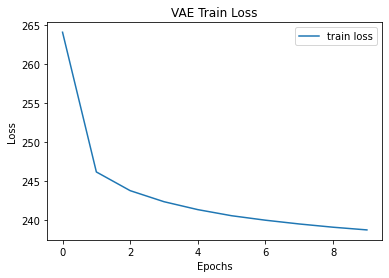

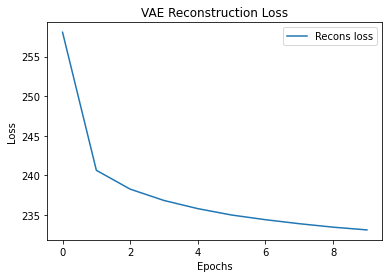

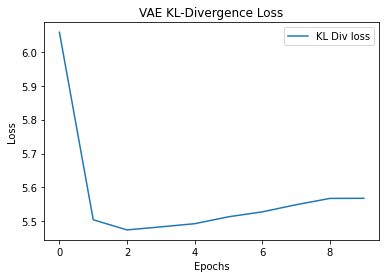

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Z dimension
ZDIM = 5

#Initialize VAE
vae = VAE(ZDIM).to(device)
#Initialize optimizer
optimizer = optim.Adam(vae.parameters(), lr = 1e-3)
#Initialize scheduler(optional)
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)
#num of epochs 
num_epochs = 10
import pdb
train_loss_list = []
recons_loss_list = []
kl_loss_list = []

orig_image_list = []
recon_image_list = []
reconst_error = []

# Define Train loop 
def train(epochs, train_loader, test_loader):
  for epoch in range(epochs):
      vae.train()
      train_loss = 0
      recons_loss = 0
      kl_loss = 0
      print('Epoch:', epoch,'LR:', scheduler.get_lr())
      for batch_idx, (data, _) in enumerate(train_loader):
          data = data.cuda()
          optimizer.zero_grad()
          recon_batch, mean, log_var = vae(data)

          loss, bce, kld = loss_function(recon_batch, data, mean, log_var)
          
          loss.backward()
          train_loss += loss.item()
          recons_loss += bce.item()
          kl_loss += kld.item()

          optimizer.step()
          # for p in vae.named_parameters():
          #   print(p)
          #   break

          if batch_idx % 100 == 0:
              recon_err = reconstruction_error(vae, test_loader)
              reconst_error.append(recon_err)
              print('Train Epoch: {} {:.0f}% \tLoss: {:.6f} \tRecon_err: {}'.format(epoch+1, 100. * batch_idx / len(train_loader), loss.item() / len(data), recon_err))
          # del data; del recon_batch; del mean; del log_var    
          
      train_loss_list.append(train_loss / len(train_loader.dataset))
      recons_loss_list.append(recons_loss / len(train_loader.dataset))
      kl_loss_list.append(kl_loss / len(train_loader.dataset))
      print('Epoch: {} Train loss: {:.4f}'.format(epoch+1, train_loss / len(train_loader.dataset)))
      scheduler.step() 

    #   recon_err = reconstruction_error(vae, test_loader)
    #   print('Epoch: {} Reconstruction Error: {:.4f}'.format(epoch+1, recon_err))
      if epoch%5==0:
        with torch.no_grad():
          
            x_batch =torch.randn(10*10, ZDIM)
            recon_batch = vae.decode(x_batch.to(device))

        orig_image_list.append(vutils.make_grid(x_batch, nrow=10 ,padding=2, normalize=True))
        recon_image_list.append(vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach().cpu(),nrow=10 , padding=2, normalize=True))

  # save the training checkpoint
  checkpoint = {'vae': vae.state_dict()}
  torch.save(checkpoint, '/content/vae_{}.pt'.format(epochs))
# Run Train loop
train(num_epochs, train_loader, test_loader)

# Plot Train loss
plt.title("VAE Train Loss")
plt.plot(train_loss_list,label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Train loss
plt.title("VAE Reconstruction Loss")
plt.plot(recons_loss_list,label="Recons loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Train loss
plt.title("VAE KL-Divergence Loss")
plt.plot(kl_loss_list,label="KL Div loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Qualitative Visualisations

### VAE Testing (TODO)

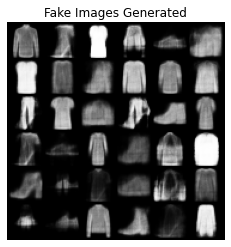

In [ ]:
vae.eval()

# Test VAE on a random sample and display on 6X6 grid
grid_size = 6 

################################
# Please fill in your code here:
with torch.no_grad():
    x_batch =torch.randn(grid_size*grid_size, ZDIM)
    recon_batch = vae.decode(x_batch.to(device))
    ims = vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach(),nrow=grid_size , padding=2, normalize=True).cpu().numpy().transpose(1, 2, 0)
    plt.imshow(ims)
    plt.axis('off')
    plt.title('Fake Images Generated')
    plt.show()

################################


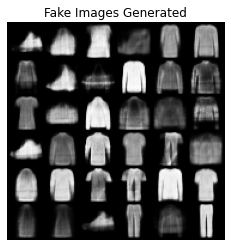

In [ ]:
vae.eval()

# Test VAE on a random sample and display on 6X6 grid
grid_size = 6 

################################
# Please fill in your code here:
with torch.no_grad():
    x_batch =torch.randn(grid_size*grid_size, ZDIM)
    recon_batch = vae.decode(x_batch.to(device))
    ims = vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach(),nrow=grid_size , padding=2, normalize=True).cpu().numpy().transpose(1, 2, 0)
    plt.imshow(ims)
    plt.axis('off')
    plt.title('Fake Images Generated')
    plt.show()

################################


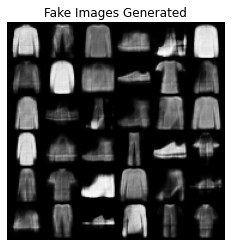

In [ ]:
vae.eval()

# Test VAE on a random sample and display on 6X6 grid
grid_size = 6 

################################
# Please fill in your code here:
with torch.no_grad():
    x_batch =torch.randn(grid_size*grid_size, ZDIM)
    recon_batch = vae.decode(x_batch.to(device))
    ims = vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach(),nrow=grid_size , padding=2, normalize=True).cpu().numpy().transpose(1, 2, 0)
    plt.imshow(ims)
    plt.axis('off')
    plt.title('Fake Images Generated')
    plt.show()

################################


### Visualize the original vs reconstructed images (TODO)

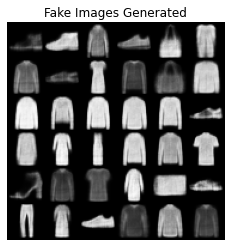

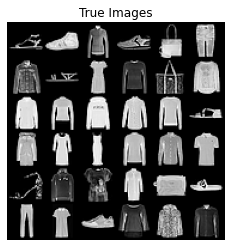

In [ ]:
with torch.no_grad():
   for batch_idx, (data, _) in enumerate(train_loader):
      data = data[:36].cuda()

      recon_batch, _, _ = vae(data.to(device))
      ims = vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach(),nrow=grid_size , padding=2, normalize=True).cpu().numpy().transpose(1, 2, 0)
      plt.imshow(ims)
      plt.axis('off')
      plt.title('Fake Images Generated')
      plt.show()
      ims = vutils.make_grid(data.view(data.shape[0], 1 , 28, 28).detach(),nrow=grid_size , padding=2, normalize=True).cpu().numpy().transpose(1, 2, 0)
      plt.imshow(ims)
      plt.axis('off')
      plt.title('True Images')
      plt.show()
      break

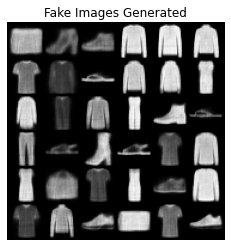

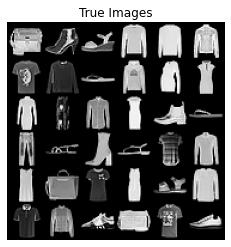

In [ ]:
# Visualise the original vs reconstructed images
# Input the 36 images in Fashion-MNIST to VAE network 
# and display reconstructed output on 6X6 grid

################################
# Please fill in your code here:
with torch.no_grad():
   for batch_idx, (data, _) in enumerate(train_loader):
      data = data[:36].cuda()

      recon_batch, _, _ = vae(data.to(device))
      ims = vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach(),nrow=grid_size , padding=2, normalize=True).cpu().numpy().transpose(1, 2, 0)
      plt.imshow(ims)
      plt.axis('off')
      plt.title('Fake Images Generated')
      plt.show()
      ims = vutils.make_grid(data.view(data.shape[0], 1 , 28, 28).detach(),nrow=grid_size , padding=2, normalize=True).cpu().numpy().transpose(1, 2, 0)
      plt.imshow(ims)
      plt.axis('off')
      plt.title('True Images')
      plt.show()
      break
################################


## Quantitative Evaluation (TODO)

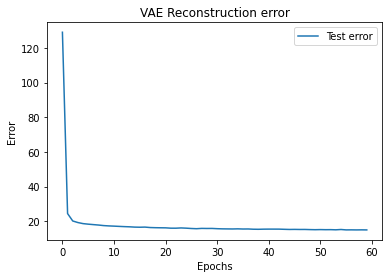

In [ ]:
# Please plot out the reconstruction error curve you saved 
# in 'reconstruction_error' list in training.
# And report the final reconstruction error value
################################
# Please fill in your code here:
plt.title("VAE Reconstruction error")
plt.plot(list(torch.stack(reconst_error).detach().cpu().numpy()),label="Test error")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()
################################


### VAE IS score

The following block create 2 torch dataset.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_saved = torch.load('/content/vae_{}.pt'.format(num_epochs))
model_vae = VAE(ZDIM)
model_vae.load_state_dict(model_saved['vae'])
model_vae.to(device)

# Prepare the torch dataset
evaluate_num = 1000
real_set = []
gen_set = []
test_batch_size = 1
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

for idx, data in enumerate(test_loader, 0):
    model_vae.eval()
    image = data[0].to(device)
    # print(image.shape)
    gen_image, _, _ = model_vae(image)

    # print(gen_image.shape)
    gen_image = gen_image.reshape(-1,28,28).unsqueeze(0)
    # print(gen_image.shape)
    
    image = image.repeat(1,3,1,1)
    gen_image = gen_image.repeat(1,3,1,1)
    real_set.append(image)
    gen_set.append(gen_image)

        
    if idx == evaluate_num-1:
        break

# make the pytorch dataset
real_set = TensorDataset(torch.cat(real_set))
gen_set = TensorDataset(torch.cat(gen_set))


#### Self-implement IS score (optional TODO)
This optional part is for implementing IS score computation following pdf instructions. You could also use the the next section "IS API" to compute the IS score.
For implementation, you would be asked to implement the most important part "compute_IS" function as an understanding of IS score computation.


In [ ]:
from torchvision.models.inception import inception_v3

def build_feature_table(dataset, model, batch_size, dim, device, upsample):
    '''
    Argms: 
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)
        up = nn.Upsample(size=(299, 299), mode='bilinear')
        with torch.no_grad():
            if upsample == True:
                # upsample to 299x299 resolution
                pred = up(image)
            else:
                pred = image
            pred = model(pred)
            # print(pred.shape)
            pred = F.softmax(pred, dim=1).cpu().numpy()
            
            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)
        del image
    assert feature_table.shape == (n, dim)
    return feature_table

def compute_IS(feature_table):
    '''
    Argms: 
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        IS_score: float
    '''
    ################################
    # Please fill in your code here:

    ################################
    return IS_score

def IS(dataset, device, upsample=True, batch_size=64, dim=1000):
    '''
    Argms: 
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
    Output:
        IS_score: float
    '''
    
    # load InveptionV3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)

    ## build up the feature table 
    feature_table = build_feature_table(dataset, model, batch_size, dim, device, upsample)

    ## IS score computation
    IS_score = compute_IS(feature_table)
    
    
    return IS_score
    


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute IS score
real_set_IS_score = IS(real_set, device, upsample = True)
gen_set_IS_score = IS(gen_set, device, upsample = True)
print('real images IS_score:', real_set_IS_score)
print('generated images IS_score:', gen_set_IS_score)

#### IS API
Here you could apply the existed API to compute IS score

In [ ]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")


print('real images IS_score:')
print(inception_score(real_set, cuda=True, batch_size=64, resize=True, splits=1))

print('generated images IS_score:')
print(inception_score(gen_set, cuda=True, batch_size=64, resize=True, splits=1))

real images IS_score:
(4.307023424719201, 0.0)
generated images IS_score:
(2.8713936473805166, 0.0)


# GAN (please restart you colab session to refresh the GPU memory usage)
### Load data for part 2.1 GAN


In [1]:
cd /content/drive/MyDrive/CIS680-VAE-GANs

/content/drive/.shortcut-targets-by-id/1NnmCrND5qB8rccGbJVC7fBwkAGmXwXnk/CIS680-VAE-GANs


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize 
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batchsize of dataset
batch_size = 128

# Load STL-10 Dataset
gan_train_dataset = datasets.STL10(root='./stl10_data/', split='train', transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)

## Model Definition (TODO)

In [14]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()
        ################################
        # Please fill in your code here:
        self.layer =  nn.Sequential(nn.ConvTranspose2d(in_channels=100,out_channels=1024,kernel_size=4,stride=1,padding=0,bias=False),
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU(),
                                    
                                    nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=(4,4),stride=(2, 2),padding=(1,1),bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(),       
                                    
                                    nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=(4,4),stride=(2, 2),padding=(1,1),bias=False),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(),
                                    
                                    nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(4,4),stride=(2, 2),padding=(1,1),bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    
                                    nn.ConvTranspose2d(in_channels=128,out_channels=3,kernel_size=(4,4),stride=(2, 2),padding=(1,1)),
                                    nn.Tanh()) 
  
        # self.apply(self._init_weights)
        ################################

    # def _init_weights(self,module):
    #     if isinstance(module, nn.ConvTranspose2d):
    #       module.weight.data.normal_(mean=0.0, std=1.0)
    #       if module.bias is not None:
    #           module.bias.data.zero_()
    #     elif isinstance(module, nn.BatchNorm2d):
    #       module.weight.data.normal_(mean=0.0, std=1.0)
    #       module.bias.data.zero_()     
    
    def forward(self, input):
        return self.layer(input)


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        ################################
        # Please fill in your code here:       
        self.layer =  nn.Sequential(nn.Conv2d(in_channels=3,out_channels=128,kernel_size=(4,4),stride=(2, 2),padding=(1, 1)),
                                    nn.LeakyReLU(0.2,inplace=True),
                                    
                                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=(2, 2),padding=(1, 1),bias=False),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.2,inplace=True),
                                    
                                    nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4),stride=(2, 2),padding=(1, 1),bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2,inplace=True),
                                    
                                    nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=(4,4),stride=(2, 2),padding=(1, 1), bias=False),
                                    nn.BatchNorm2d(1024),
                                    nn.LeakyReLU(0.2,inplace=True),
                                    
                                    nn.Conv2d(in_channels=1024,out_channels=1,kernel_size=(4,4),stride = (1, 1),padding=0),
                                    nn.Sigmoid())
        # self.apply(self._init_weights)
        ################################
    
    # def _init_weights(self,module):
    #     if isinstance(module, nn.Conv2d):
    #       module.weight.data.normal_(mean=0.0, std=1.0)
    #       if module.bias is not None:
    #           module.bias.data.zero_()
    #     elif isinstance(module, nn.BatchNorm2d):
    #       module.weight.data.normal_(mean=0.0, std=1.0)
    #       module.bias.data.zero_()
        
    def forward(self, input):
        return self.layer(input)

In [41]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()
        ################################
        # Please fill in your code here:
        self.layer =  nn.Sequential(nn.ConvTranspose2d(in_channels=100,out_channels=1024,kernel_size=4,stride=1,padding=0,bias=False),
                            nn.BatchNorm2d(1024),
                            nn.ReLU(),
                            
                            nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=(4,4),stride=(2, 2),padding=(1,1),bias=False),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),       
                            
                            nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=(4,4),stride=(2, 2),padding=(1,1),bias=False),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            
                            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(4,4),stride=(2, 2),padding=(1,1),bias=False),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            
                            nn.ConvTranspose2d(in_channels=128,out_channels=3,kernel_size=(4,4),stride=(2, 2),padding=(1,1)),
                            nn.Tanh()) 

        # self.apply(self._init_weights)
        ################################

    # def _init_weights(self,module):
    #     if isinstance(module, nn.ConvTranspose2d):
    #       module.weight.data.normal_(mean=0.0, std=1.0)
    #       if module.bias is not None:
    #           module.bias.data.zero_()
    #     elif isinstance(module, nn.BatchNorm2d):
    #       module.weight.data.normal_(mean=0.0, std=1.0)
    #       module.bias.data.zero_()     
    
    def forward(self, input):
        return self.layer(input)



In [42]:
netG = DCGAN_Generator()
netG

DCGAN_Generator(
  (layer): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

## GAN Training

### GAN loss (TODO)

In [ ]:
import torch

fake = torch.load('test_case_GAN/fake.pt')
netD = torch.load('test_case_GAN/netD.pt')
real = torch.load('test_case_GAN/real.pt')
netG = torch.load('test_case_GAN/netG.pt')
noise = torch.load('test_case_GAN/noise.pt')
Valid_label = torch.load('test_case_GAN/Valid_label.pt')
Fake_label = torch.load('test_case_GAN/Fake_label.pt')
criterion = torch.load('test_case_GAN/criterion.pt')


def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion):
    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''
    
    # return total loss_D and fake images
    loss_D = criterion(torch.squeeze(D(real)),Valid_label)

    fake = G(noise)

    loss_D += criterion(torch.squeeze(D(fake.detach())),Fake_label)

    return loss_D, fake

def loss_generator(D, fake, Valid_label, criterion):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    # no detach - fake 
    loss_G = criterion(torch.squeeze(D(fake)),Valid_label)
    return loss_G


loss_D, fake_G = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)
# torch.save(loss_D, 'test_case_GAN/loss_D.pt')
loss_G = loss_generator(netD, fake, Valid_label, criterion)
# torch.save(loss_G, 'test_case_GAN/loss_G.pt')


test_loss_D = torch.load('test_case_GAN/loss_D.pt')
test_loss_G = torch.load('test_case_GAN/loss_G.pt')

print('test case loss_D:', test_loss_D.item())
print('computed loss_D:', loss_D.item())

print('test case loss_G:', test_loss_G.item())
print('computed loss_G:', loss_G.item())


test case loss_D: 1.3626351356506348
computed loss_D: 1.3626351356506348
test case loss_G: 0.7321602702140808
computed loss_G: 0.7321602702140808


### Training block

[0/100][0/40]	Loss_D: 1.4190	Loss_G: 0.9552	
[1/100][0/40]	Loss_D: 0.0433	Loss_G: 4.1073	
[2/100][0/40]	Loss_D: 0.6882	Loss_G: 2.5223	
[3/100][0/40]	Loss_D: 0.0218	Loss_G: 5.2552	
[4/100][0/40]	Loss_D: 0.8279	Loss_G: 1.7277	
[5/100][0/40]	Loss_D: 0.3619	Loss_G: 3.4237	
[6/100][0/40]	Loss_D: 0.9212	Loss_G: 2.7311	
[7/100][0/40]	Loss_D: 0.8000	Loss_G: 2.0487	
[8/100][0/40]	Loss_D: 0.7917	Loss_G: 3.7969	
[9/100][0/40]	Loss_D: 0.7621	Loss_G: 5.6552	
[10/100][0/40]	Loss_D: 0.6658	Loss_G: 3.8600	
[11/100][0/40]	Loss_D: 0.8102	Loss_G: 2.5687	
[12/100][0/40]	Loss_D: 0.8937	Loss_G: 2.6153	
[13/100][0/40]	Loss_D: 2.1548	Loss_G: 4.0736	
[14/100][0/40]	Loss_D: 1.1453	Loss_G: 2.8832	
[15/100][0/40]	Loss_D: 1.9384	Loss_G: 4.9290	
[16/100][0/40]	Loss_D: 0.9019	Loss_G: 4.5798	
[17/100][0/40]	Loss_D: 0.8091	Loss_G: 2.0686	
[18/100][0/40]	Loss_D: 1.5534	Loss_G: 5.0906	
[19/100][0/40]	Loss_D: 1.0646	Loss_G: 4.6672	
[20/100][0/40]	Loss_D: 1.1573	Loss_G: 5.3550	
[21/100][0/40]	Loss_D: 0.8252	Loss_G: 1.2940

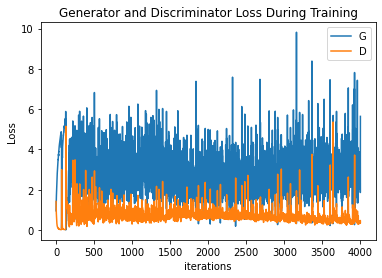

In [ ]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)


# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 100

  
# def load_param(num_eps):
#   model_saved = torch.load('/content/drive/MyDrive/CIS680-VAE-GANs/gan_{}.pt'.format(num_eps))
#   netG.load_state_dict(model_saved['netG'])
#   netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        # Function to compute discriminator loss
        loss_D, fake = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)

        # pdb.set_trace()
        loss_D.backward()
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Function to compute generator loss
        loss_G = loss_generator(netD, fake, Valid_label, criterion)
        # Calculate gradients for G
        loss_G.backward()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake,nrow=6, padding=2, normalize=True))

        iters += 1

# checkpoint = {'netG': netG.state_dict(),
#       'netD': netD.state_dict()}
# torch.save(checkpoint, '/content/drive/MyDrive/CIS680-VAE-GANs/gan_{}.pt'.format(epoch+1))
      

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Qualitative Visualisations

### GAN Testing (TODO)

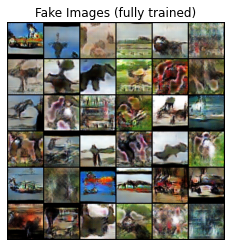

In [ ]:
# Test GAN on a random sample and display on 6X6 grid

################################
# Please fill in your code here:
with torch.no_grad():
    b_size = 36
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise)
    ims = vutils.make_grid(fake, nrow=6, padding=2, normalize=True).cpu().numpy().transpose(1, 2, 0)
    plt.imshow(ims)
    plt.axis('off')
    plt.title('Fake Images')
    plt.show()
################################

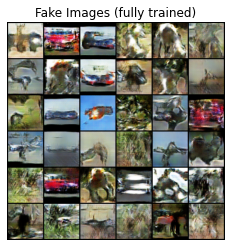

In [ ]:
# Test GAN on a random sample and display on 6X6 grid

################################
# Please fill in your code here:
with torch.no_grad():
    b_size = 36
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise)
    ims = vutils.make_grid(fake, nrow=6, padding=2, normalize=True).cpu().numpy().transpose(1, 2, 0)
    plt.imshow(ims)
    plt.axis('off')
    plt.title('Fake Images (fully trained)')
    plt.show()
################################

### Visualisation at different epochs (TODO)

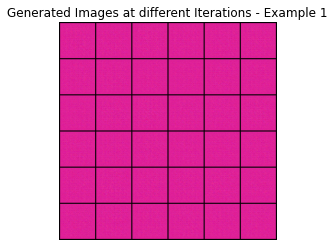

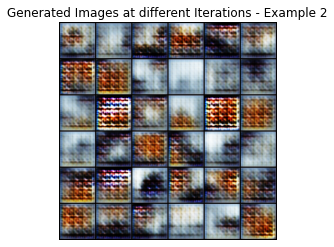

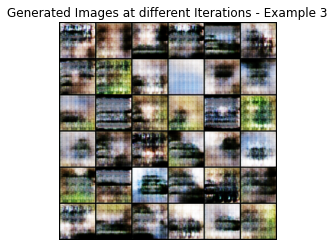

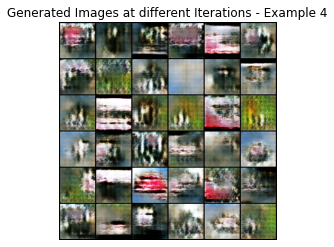

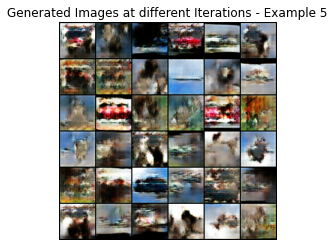

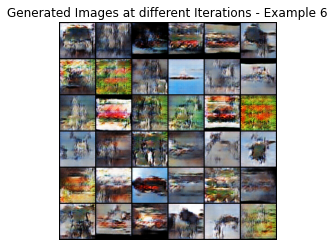

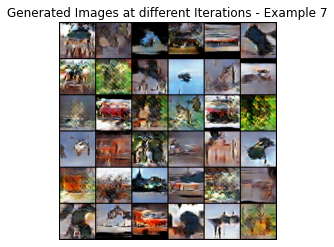

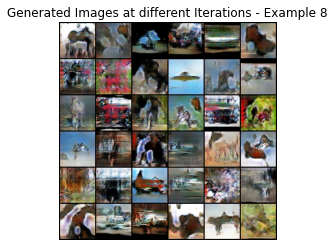

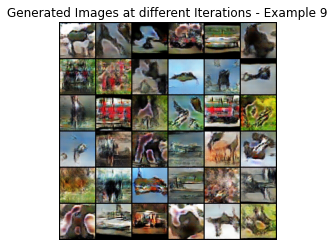

In [ ]:
# Plot GAN generated images at different epochs during training
################################
# Please fill in your code here:
for idx, img in enumerate(img_list):
    plt.imshow(img.cpu().numpy().transpose(1, 2, 0))
    plt.title('Generated Images at different Iterations - Example '+str(idx+1))
    plt.axis('off')
    plt.show()
################################


## Quantitative Evaluation

In [5]:
# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize 
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load STL-10 test set
test_batch_size = 1
gan_test_dataset = datasets.STL10(root='./stl10_data/', split='test', transform=transform, download=True)
gan_test_loader = torch.utils.data.DataLoader(dataset=gan_test_dataset, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified


### FID score for GAN
This part, you would be asked to compute a FID score between the real image and the generated images to evaluate the photo-realistic quality of the generated images. 
For this part, we should create three folder: 
- 1. STL_10_real_1 
- 2. STL_10_real_2 
- 3. STL_10_fake


In [8]:
pwd

'/content/drive/.shortcut-targets-by-id/1NnmCrND5qB8rccGbJVC7fBwkAGmXwXnk/CIS680-VAE-GANs'

In [10]:
cd /content/drive/MyDrive/CIS680-VAE-GANs/GAN_images

/content/drive/.shortcut-targets-by-id/1NnmCrND5qB8rccGbJVC7fBwkAGmXwXnk/CIS680-VAE-GANs/GAN_images


In [11]:
! mkdir STL_10_fake STL_10_real_1 STL_10_real_2

Create the dataset to evaluate quantitative scores.

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128
# Load checkpoint
model_saved = torch.load('/content/drive/MyDrive/CIS680-VAE-GANs/gan_final.pt')
netG = DCGAN_Generator()
netG.load_state_dict(new_key)
netG.to(device)


def denorm(x, norm_mean, norm_std):
    y = torch.zeros(x.shape)
    y[:,0,:,:] = x[:,0,:,:]*norm_std[0] + norm_mean[0]
    y[:,1,:,:] = x[:,1,:,:]*norm_std[1] + norm_mean[1]
    y[:,2,:,:] = x[:,2,:,:]*norm_std[2] + norm_mean[2]
    return y



evaluate_num = 1000

# make the gen data set and folder
gen_set = []
for idx in range(evaluate_num):
    with torch.no_grad():
        fixed_noise = torch.randn(1, nz, 1, 1, device=device)
        fake = netG(fixed_noise).detach().cpu()
        fake = fake.cpu().detach()
        fake_denorm = denorm(fake, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # print(fake_denorm.shape)
        gen_set.append(fake_denorm)
        
        # plt.imshow(np.transpose(vutils.make_grid(fake, nrow=6 ,padding=2, normalize=True),(1,2,0)), animated=True)
        save_image(fake.squeeze(), './STL_10_fake/fake' + str(idx) + '.png', normalize=True)

gen_dataset = TensorDataset(torch.cat(gen_set))

# make the real data set and folder
real_set_1 = []
real_set_2 = []

for idx, data in enumerate(gan_test_loader, 0):
    image = data[0]
    # print(image.shape)
    image_denorm = denorm(image, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    if idx < evaluate_num:
        real_set_1.append(image_denorm)
        save_image(image.squeeze(), './STL_10_real_1/real' + str(idx) + '.png', normalize=True)
    elif evaluate_num <= idx < 2*evaluate_num:
        real_set_2.append(image_denorm)
        save_image(image.squeeze(), './STL_10_real_2/real' + str(idx) + '.png', normalize=True)
    if idx == 2*evaluate_num-1:
        break

# make the pytorch dataset
real_dataset_1 = TensorDataset(torch.cat(real_set_1))
real_dataset_2 = TensorDataset(torch.cat(real_set_2))


#### Self-implement FID score (optional TODO)
This optional part is for implementing FID score computation following pdf instructions. Implement "compute_FID" function which is the most important part in FID score computation. You could also use the the next section "FID API" to compute the FID score.

In [ ]:
! pip install pytorch-fid
from pytorch_fid.inception import InceptionV3

def build_feature_table(dataset, model, batch_size, dim, device):
    '''
    Argms: 
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)
        
        with torch.no_grad():
            pred = model(image)[0]
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)
    
    return feature_table

def compute_stat(feature_table):
    '''
    Argms: 
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        mu: mean along row dimension
        sigma: covarance matrix of dataset
    '''
    # compute mean and sigma based on activation table
    mu = np.mean(feature_table, axis=0)
    sigma = np.cov(feature_table, rowvar=False)

    # print('dimension of mu', mu.shape)
    # print('dimension of sigma', sigma.shape)
    return mu, sigma


def compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6):
    '''
    Argms: 
    Input:
        mu_1: mean vector we get for dataset1 
        sigma_1: covariance matrix for dataset1
        mu_2: mean vector we get for dataset2 
        sigma_2: covariance matrix for dataset1
    Output:
        FID score: float
    '''
    
    # compute mu difference

    # compute square root of Sigma1*Sigma2 using "linalg.sqrtm" from scipy 
    # please name the resulting matrix as covmean

    # The following block take care of imagionary part of covmean 
    #################################################################
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma_1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma_1 + offset).dot(sigma_2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    #################################################################

    # compute FID score, based on eqution.(10) in pdf FID part.
    

    return FID_score

def FID(dataset_1, dataset_2, device, batch_size=64, dim=2048, block_idx = 3):
    '''
    Argms: 
    Input:
        dataset_1: pytorch dataset
        dataset_2: pytorch dataset
        device: device type torch.device("cuda:0") or torch.device("cpu")
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        block_idx: the block stage index we want to use in inception module
    Output:
        FID_score: float
    '''
    # load InveptionV3 model
    model = InceptionV3([block_idx]).to(device)

    ## build up the feature table 
    feature_table_1 = build_feature_table(dataset_1, model, batch_size, dim, device)
    feature_table_2 = build_feature_table(dataset_2, model, batch_size, dim, device)


    ## compute mu, sigma for dataset 1&2
    mu_1, sigma_1 = compute_stat(feature_table_1)
    mu_2, sigma_2 = compute_stat(feature_table_2)


    ## FID score computation
    FID_score = compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6)
    
    
    return FID_score


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute FID using FID function you implemented above
FID_score = FID(real_dataset_1, real_dataset_1, device)
print('FID_score between real_dataset_1 and itself:', FID_score)

FID_score = FID(real_dataset_1, real_dataset_2, device)
print('FID_score between real_dataset_1 and real_dataset_2:', FID_score)

FID_score = FID(real_dataset_1, gen_dataset, device)
print('FID_score between real_dataset_1 and generated image set:', FID_score)

#### FID API

In [ ]:
'/content/drive/MyDrive/CIS680-VAE-GANs'

In [ ]:
! pip install pytorch-fid
! python -m pytorch_fid '/content/drive/MyDrive/CIS680-VAE-GANs/STL_10_real_1' '/content/drive/MyDrive/CIS680-VAE-GANs/STL_10_real_1' 
! python -m pytorch_fid '/content/drive/MyDrive/CIS680-VAE-GANs/STL_10_real_1' '/content/drive/MyDrive/CIS680-VAE-GANs/STL_10_real_2' 
! python -m pytorch_fid '/content/drive/MyDrive/CIS680-VAE-GANs/STL_10_real_1' '/content/drive/MyDrive/CIS680-VAE-GANs/STL_10_fake' 


In [ ]:
! pip install pytorch-fid
! python -m pytorch_fid '/content/drive/MyDrive/CIS680-VAE-GANs/STL_10_real_1' '/content/drive/MyDrive/CIS680-VAE-GANs/STL_10_real_1' 
! python -m pytorch_fid '/content/drive/MyDrive/CIS680-VAE-GANs/STL_10_real_1' '/content/drive/MyDrive/CIS680-VAE-GANs/STL_10_real_2' 
! python -m pytorch_fid '/content/drive/MyDrive/CIS680-VAE-GANs/STL_10_real_1' '/content/drive/MyDrive/CIS680-VAE-GANs/STL_10_fake' 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:01<00:00, 64.8MB/s]
100% 20/20 [00:06<00:00,  3.15it/s]
100% 20/20 [00:04<00:00,  4.80it/s]
FID:  -2.2148069376726198e-05
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils

If you implement the self-implement FID version. You would notice a negligible difference in value. Because the API package compute this value by saving and reading tensor from .png files. Accuracy problem could happen in the middle of transation.

### IS score for GAN

#### Self-implement IS score (optional)

You could copy and paste this function from VAE part if you have implement that part.


In [ ]:
from torchvision.models.inception import inception_v3

def build_feature_table(dataset, model, batch_size, dim, device, upsample):
    '''
    Argms: 
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)
        up = nn.Upsample(size=(299, 299), mode='bilinear')
        with torch.no_grad():
            if upsample == True:
                # upsample to 299x299 resolution
                pred = up(image)
            pred = model(pred)
            # print(pred.shape)
            pred = F.softmax(pred, dim=1).cpu().numpy()
            
            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)
    assert feature_table.shape == (n, dim)
    return feature_table

def compute_IS(feature_table):
    '''
    Argms: 
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        IS_score: float
    '''
    ################################
    # Please fill in your code here:

    ################################
    return IS_score

def IS(dataset, device, upsample=True, batch_size=64, dim=1000):
    '''
    Argms: 
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
    Output:
        IS_score: float
    '''
    
    # load InveptionV3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)

    ## build up the feature table 
    feature_table = build_feature_table(dataset, model, batch_size, dim, device, upsample)

    ## IS score computation
    IS_score = compute_IS(feature_table)
    
    
    return IS_score
    


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute IS score
real_set_IS_score = IS(real_dataset_1, device, upsample = True)
gen_set_IS_score = IS(gen_dataset, device, upsample = True)
print('real images IS_score:', real_set_IS_score)
print('generated images IS_score:', gen_set_IS_score)

#### IS API

In [47]:
cd '/content/drive/MyDrive/CIS680-VAE-GANs'

/content/drive/.shortcut-targets-by-id/1NnmCrND5qB8rccGbJVC7fBwkAGmXwXnk/CIS680-VAE-GANs


In [48]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")

print('IS score for real data set 1:')
print(inception_score(real_dataset_1, cuda=True, batch_size=64, resize=True, splits=1))
print('IS score for real data set 2:')
print(inception_score(real_dataset_2, cuda=True, batch_size=64, resize=True, splits=1))
print('IS score for generated data set:')
print(inception_score(gen_dataset, cuda=True, batch_size=64, resize=True, splits=1))

IS score for real data set 1:


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

(14.623438496656947, 0.0)
IS score for real data set 2:
(15.913449718671151, 0.0)
IS score for generated data set:
(2.352483433176131, 0.0)
